### Importing neessary libraries

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
#Train test split
from sklearn.model_selection import train_test_split
#Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

### Reading the file

In [31]:
df = pd.read_excel('rnn_lstm.xlsx')
df.head()

,id,likesCount,ownerProfilePicUrl,ownerUsername,postUrl,Unnamed: 5,text,Unnamed: 7,timestamp
0,17988118445479198,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,frank21327,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I was afraid to start but when I did I was so ...,Scam,2023-08-01T00:02:06.000Z
1,17995515296305509,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,lawrence____larry.10,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I’m paying 5 grands to the first 7 people to m...,Scam,2023-08-01T00:02:44.000Z
2,17975784647410597,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,mari_o9754,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,@madison_exchange_1 I was referred to this pla...,Scam,2023-08-01T00:03:38.000Z
3,18375946198053653,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,howard____thopson,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,PAYING 5 GRAND TO The First 5 People To Messag...,Scam,2023-08-01T00:04:17.000Z
4,17965259663603317,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,elly_x_elias,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I never believe I could get my partner back. I...,Scam,2023-08-01T00:04:57.000Z


In [ ]:
columns = df.columns
columns

Index(['id', 'likesCount', 'ownerProfilePicUrl', 'ownerUsername', 'postUrl',
       'Unnamed: 5', 'text', 'Unnamed: 7', 'timestamp'],
      dtype='object')

In [ ]:
# renaming the unnamed 7 column as the label column

df.rename(columns={'Unnamed: 7':'label'}, inplace=True)
df.head()

,id,likesCount,ownerProfilePicUrl,ownerUsername,postUrl,Unnamed: 5,text,label,timestamp
0,17988118445479198,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,frank21327,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I was afraid to start but when I did I was so ...,Scam,2023-08-01T00:02:06.000Z
1,17995515296305509,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,lawrence____larry.10,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I’m paying 5 grands to the first 7 people to m...,Scam,2023-08-01T00:02:44.000Z
2,17975784647410597,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,mari_o9754,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,@madison_exchange_1 I was referred to this pla...,Scam,2023-08-01T00:03:38.000Z
3,18375946198053653,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,howard____thopson,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,PAYING 5 GRAND TO The First 5 People To Messag...,Scam,2023-08-01T00:04:17.000Z
4,17965259663603317,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,elly_x_elias,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I never believe I could get my partner back. I...,Scam,2023-08-01T00:04:57.000Z


### Extracting the texts and the labels needed for the model

In [ ]:
df_req = df[['text', 'label']]
df_req.head()

,text,label
0,I was afraid to start but when I did I was so ...,Scam
1,I’m paying 5 grands to the first 7 people to m...,Scam
2,@madison_exchange_1 I was referred to this pla...,Scam
3,PAYING 5 GRAND TO The First 5 People To Messag...,Scam
4,I never believe I could get my partner back. I...,Scam


In [ ]:
df_req.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1964 non-null   object
 1   label   274 non-null    object
dtypes: object(2)
memory usage: 34.5+ KB


### Labeling the unlabelled labels

In [33]:
df_req['label'] = df_req['label'].apply(lambda x: 'Scam' if x == 'Scam' else 'Not Scam')

C:\Users\oyeni\AppData\Local\Temp\ipykernel_11204\1061086029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_req['label'] = df_req['label'].apply(lambda x: 'Scam' if x == 'Scam' else 'Not Scam')


0       I was afraid to start but when I did I was so ...
1       I’m paying 5 grands to the first 7 people to m...
2       @madison_exchange_1 I was referred to this pla...
3       PAYING 5 GRAND TO The First 5 People To Messag...
4       I never believe I could get my partner back. I...
                              ...                        
2194                              I saw this, it was good
2195                                     @dancindome same
2196    @gailjjones Me neither. What’s going on. Did t...
2197                       This mom is a horrible person.
2198                                        What season ?
Name: text, Length: 2199, dtype: object

#### Checking for the most/ frequently occuring word in the texts

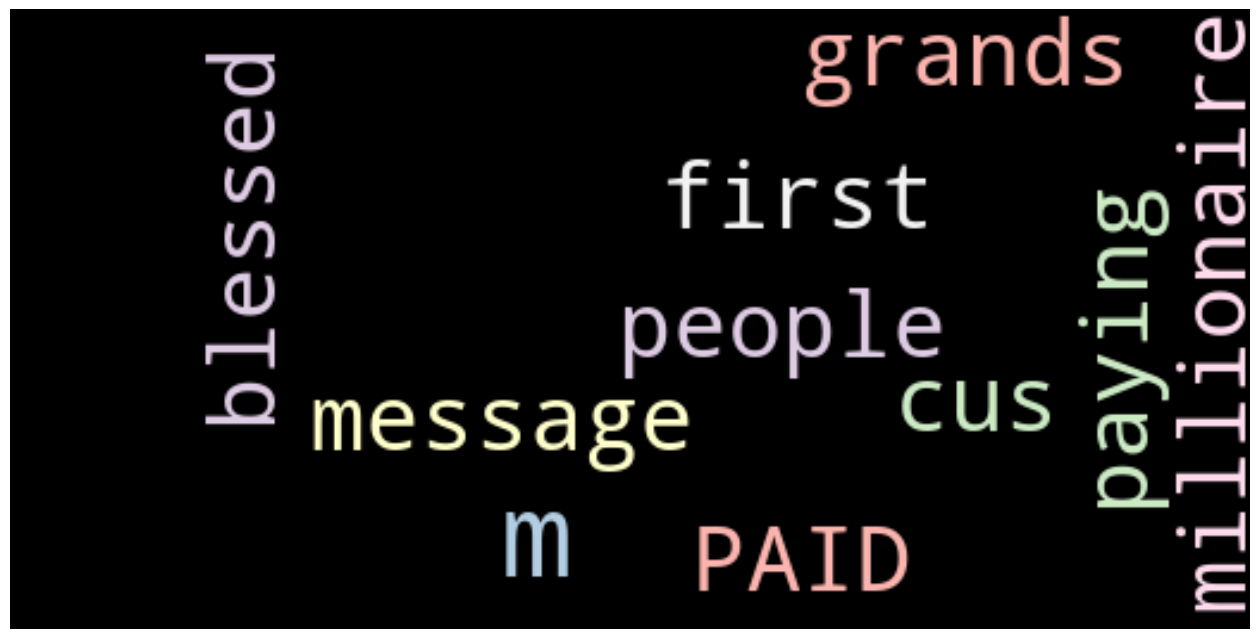

In [38]:
message_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS,
                           max_font_size = 50, background_color = "black",
                             colormap = 'Pastel1').generate(df_req['text'][1])
plt.figure(figsize=(16,10))
plt.imshow(message_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()